In [4]:
from itertools import product
import tqdm
import time
import editdistance 
import matplotlib.pyplot as plt
import plotly.express as px
import random

import pandas as pd
import numpy as np
import numba as nb
from numba import njit, jit, prange, cuda, objmode
from numba.typed import List
from numba.experimental import jitclass
import plotly.graph_objects as go
import random
from collections import defaultdict
from tqdm import tqdm
np.random.seed(0)
random.seed(0)

# Definitions 

In [5]:
@njit(fastmath=True)
def l2_dist(a, b): 
    d = a-b
    return np.sum(d*d);

@njit(fastmath=True)
def hamming_distance(a, b):
    return np.sum(a != b);

# only works for k<=32, would overflow otherwise 
@njit(fastmath=True)
def extract_kmers(seq,k):
    kmer = 0
    kmers = np.zeros(len(seq)-k+1,dtype=np.int64)
    for i,c in enumerate(seq):
        kmer = kmer * 4 + c
        kmer = kmer % (4**k)
        if i>=k:
            kmers[i-k] = kmer
    return kmers

@jitclass([
    ('A', nb.int32),
    ('t', nb.int32),
    ('D', nb.int32),
    ('normalize', nb.bool_),
    ('hashes', nb.int32[:, :]),
    ('signs', nb.float32[:, :])])
class TS():
    def __init__(self, t, D, A, normalize = True):
        self.A = A
        self.t = t
        self.D = D
        self.normalize = normalize

        # An A*t array of random integers in [0, D)
        self.hashes = np.empty((self.A, self.t), dtype=np.int32)
        # An A*t array of random +-1
        self.signs = np.empty((self.A, self.t), dtype=np.float32)
        for c in range(self.A):
            for k in range(self.t):
                self.hashes[c][k] = random.randrange(0, self.D)
                self.signs[c][k] = random.randrange(-1, 2, 2)

    def _full_sketch(self, seq: nb.int32[:]):
        # NOTE: The sketch is stored as float64 here so counting won't overflow.
        T = np.zeros((self.t + 1, self.D), dtype=np.float64)
        T[0][0] = 1
        
        for c in seq:
            for k in range(self.t - 1, -1, -1):
                h = self.hashes[c][k]
                s = self.signs[c][k]
                for l in range(self.D):
                    r = l + h if l + h < self.D else l + h - self.D
                    T[k + 1][l] += s * T[k][r]

        return T

    def _normalize(self, seq, T)-> nb.float32[:]:
        if self.normalize:
            T = T / np.linalg.norm(T)
        return T

    def sketch_one(self, seq: np.ndarray) -> nb.float32[:]:
        full_sketch = self._full_sketch(seq)

        sketch = self._normalize(seq, full_sketch[self.t])

        sketch = sketch.flatten()
        return sketch

    def sketch(self, seqs):
        return [self.sketch_one(seq) for seq in seqs]

    def dist(self, s1, s2):
        return l2_dist(s1,s2)
    
class TSS():
    def __init__(self, seq_len, t, W, S, D, A, normalize = True, sketch_class=TS):
        # reduce sketch dim to ensure that the flattened sketch size is D 
        D2 = int(D/int((seq_len-W)/S)+1)   
        self.sketcher = sketch_class(t=t,D=D2,A=A,normalize=normalize)
        self.t = t
        self.W = W
        self.S = S
        self.D2 = D2
        self.D = D
    
    def sketch_one(self, seq: nb.int32[:]) -> nb.float32[:,:]:
        L = int(np.ceil((len(seq)-self.W+1)/self.S))
        sketch = np.zeros((self.D2,L), dtype=np.float32)
        for si,i in enumerate(np.arange(0,len(seq)-self.W+1,self.S)):
            sketch[:,si] = self.sketcher.sketch_one(seq[i:i+self.W])
        
        return sketch
    
    def sketch(self, seqs):
        all_seqs = List()
        starts = np.arange(0,len(seqs[0])-self.W+1,self.S)
        n, m = len(seqs),len(starts)
        for seq in seqs:
            for i in starts:
                all_seqs.append(seq[i:i+self.W])
        all_sketches = self.sketcher.sketch(all_seqs)
        sketches = List()
        for i in range(n):
            sk = np.array([x for sk in all_sketches[i*m:(i+1) * m] for x in sk])
            sketches.append(sk)
        return sketches
    
    def dist(self, s1, s2):
        return l2_dist(s1,s2)

@jitclass([
    ('A', nb.int32),
    ('t', nb.int32),
    ('D', nb.int32),
    ('D2', nb.int32),
    ('normalize', nb.bool_),
    ('hashes', nb.int32[:, :]),
    ('G', nb.float64[:, :]),
    ('H', nb.float64[:]),
    ('signs', nb.float32[:, :])])
class DTS():
    def __init__(self, t, D, D2, A, normalize = True):
        self.A = A
        self.t = t
        self.D = D
        self.D2 = D2
        self.normalize = normalize

        # An A*t array of random integers in [0, D)
        self.hashes = np.empty((self.A, self.t), dtype=np.int32)
        # An A*t array of random +-1
        self.signs = np.empty((self.A, self.t), dtype=np.float32)
        # Gaussian matrix for discretization
        self.G = np.empty((self.D , self.D2), dtype=np.float64)
        for i in range(self.D):
            for j in range(self.D2):
                self.G[i,j] = random.normalvariate(0,1)
                
        for c in range(self.A):
            for k in range(self.t):
                self.hashes[c][k] = random.randrange(0, self.D)
                self.signs[c][k] = random.randrange(-1, 2, 2)

    def _full_sketch(self, seq: nb.int32[:]):
        # NOTE: The sketch is stored as float64 here so counting won't overflow.
        T = np.zeros((self.t + 1, self.D), dtype=np.float64)
        T[0][0] = 1
        
        for c in seq:
            for k in range(self.t - 1, -1, -1):
                h = self.hashes[c][k]
                s = self.signs[c][k]
                for l in range(self.D):
                    r = l + h if l + h < self.D else l + h - self.D
                    T[k + 1][l] += s * T[k][r]

        return T

    def _normalize(self, seq, T)-> nb.float32[:]:
        if self.normalize:
            T = T / np.linalg.norm(T)
        return T
    

    def discretize(self, x: nb.float64[:]) -> np.int64:
        x = x.dot(self.G)
#         H = np.tensordot(self.G, x, axes=(1, 0))
        H = (x>0)
        H = H.reshape(-1,8)
        S = np.zeros((H.shape[0]),np.int64)
        for i in range(H.shape[0]):
            arr = H[i]
            S[i] = (arr[0]<<8) + (arr[0]<<7)|(arr[1]<<6)|(arr[2]<<5)|(arr[3]<<4)|(arr[4]<<3)|(arr[5]<<2)|(arr[6]<<1)|arr[7]
        sh = 0
        for s in S:
            sh = hash(sh) ^ hash(str(s))
        return sh

    def sketch_one(self, seq: np.ndarray)-> np.int64: #-> nb.float32[:]:
        full_sketch = self._full_sketch(seq)

        sketch = self._normalize(seq, full_sketch[self.t])
        sketch = sketch.flatten()
        sketch = self.discretize(sketch)
        return sketch

    def sketch(self, seqs):
        sketches = np.zeros((len(seqs)),np.int64)
        for i in range(len(seqs)):
            sketches[i] = self.sketch_one(seqs[i])
        return sketches
        # return [self.sketch_one(seq) for seq in seqs]

    def dist(self, s1, s2):
        return l2_dist(s1,s2)
    

def mutate(seq, alphabet, rate):
    new_seq = []
    n = len(seq)
    i = 0
    alg = []
    while i < n:
        chance = np.random.uniform()
        if chance > rate:
            # do nothing
            alg.append(i)
            new_seq.append(seq[i])
            i += 1
        else:
            # choose at random an operation between substitution, insertion, deletion
            op = np.random.choice([0,1,2])            
            if op == 0:
                # substitution
                c = np.random.choice(list(set(alphabet) - set([seq[i]])))
                new_seq.append(c)
                alg.append(i)
                i += 1
            elif op == 1:
                # insertion
                c = np.random.choice(alphabet)
                alg.append(i)
                new_seq.append(c)
            elif op == 2:
                # deletion
                i += 1
    D = len(seq) - len(new_seq)
    new_seq = new_seq + [np.random.choice(alphabet) for _ in range(D)]
    alg = alg + [i for _ in range(D)]
    return ''.join(new_seq),alg
    
def convert(seq, alphabet):
    inv_map = {alphabet[i]:i for i in range(len(alphabet))}
    new_seq = []
    for c in seq:
        new_seq.append(inv_map[c])
    return np.asarray(new_seq, dtype=np.uint8)

def generate_paths(seq, path_len, num_paths, k, mutation_rate, alphabet):
    paths = []
    for i in range(num_paths):
        # pick random index
        start = np.random.choice(len(seq) - path_len)
        path = seq[start:start+path_len]
        seq2,align =  mutate(path, alphabet, mutation_rate)
        nodes = [start+i for i in align]
        paths.append((path,seq2, nodes))
    return paths

def build_lookup(sketches, stride):
    lut = defaultdict(list)
    for i, s in enumerate(sketches):
        lut[s].append(i*stride)
    return lut

def dict_configs(d):
    for k,v in d.items():
        if not isinstance(v,list):
            d[k] = [v]
    for vcomb in product(*d.values()):
        yield dict(zip(d.keys(), vcomb))

# Experiment 

100%|██████████| 1000/1000 [00:02<00:00, 395.15it/s]


{'num_paths': 1000, 'N': 1000000, 'mr': 0.1, 'path_len': 200, 'recall_dist': 0, 'k': 14, 'm': 20, 'm2': 128, 'tuplen': 3, 'w': 14, 's': 14, 'P': 0.6380414058303505, 'R': 0.948, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([948,   9,  20,   0,   0,   0,   1,   0,   1,  21])}


100%|██████████| 1000/1000 [00:02<00:00, 397.64it/s]


{'num_paths': 1000, 'N': 1000000, 'mr': 0.1, 'path_len': 200, 'recall_dist': 0, 'k': 14, 'm': 20, 'm2': 128, 'tuplen': 4, 'w': 14, 's': 14, 'P': 0.9503584359745255, 'R': 0.956, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([956,   7,  18,   0,   0,   0,   0,   0,   0,  19])}


100%|██████████| 1000/1000 [00:02<00:00, 371.23it/s]


{'num_paths': 1000, 'N': 1000000, 'mr': 0.1, 'path_len': 200, 'recall_dist': 0, 'k': 14, 'm': 20, 'm2': 128, 'tuplen': 5, 'w': 14, 's': 14, 'P': 0.9522916464617075, 'R': 0.953, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([953,  10,  19,   0,   0,   0,   0,   0,   0,  18])}


100%|██████████| 1000/1000 [00:02<00:00, 407.50it/s]


{'num_paths': 1000, 'N': 1000000, 'mr': 0.15, 'path_len': 200, 'recall_dist': 0, 'k': 14, 'm': 20, 'm2': 128, 'tuplen': 3, 'w': 14, 's': 14, 'P': 0.7941755674232309, 'R': 0.765, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([765,  10,  26,   1,   2,   0,   0,   0,   1, 195])}


100%|██████████| 1000/1000 [00:02<00:00, 404.89it/s]


{'num_paths': 1000, 'N': 1000000, 'mr': 0.15, 'path_len': 200, 'recall_dist': 0, 'k': 14, 'm': 20, 'm2': 128, 'tuplen': 4, 'w': 14, 's': 14, 'P': 0.9002361275088547, 'R': 0.794, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([794,  14,  21,   0,   0,   0,   0,   0,   0, 171])}


100%|██████████| 1000/1000 [00:02<00:00, 385.58it/s]


{'num_paths': 1000, 'N': 1000000, 'mr': 0.15, 'path_len': 200, 'recall_dist': 0, 'k': 14, 'm': 20, 'm2': 128, 'tuplen': 5, 'w': 14, 's': 14, 'P': 0.9494190705128205, 'R': 0.802, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([802,   2,  20,   1,   0,   0,   0,   0,   0, 175])}


100%|██████████| 1000/1000 [00:02<00:00, 398.66it/s]


{'num_paths': 1000, 'N': 1000000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 0, 'k': 14, 'm': 20, 'm2': 128, 'tuplen': 3, 'w': 14, 's': 14, 'P': 0.252604412354678, 'R': 0.514, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([514,  17,  27,   1,   3,   0,   3,   0,   4, 431])}


100%|██████████| 1000/1000 [00:02<00:00, 399.22it/s]


{'num_paths': 1000, 'N': 1000000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 0, 'k': 14, 'm': 20, 'm2': 128, 'tuplen': 4, 'w': 14, 's': 14, 'P': 0.9030079803560466, 'R': 0.503, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([503,  12,  16,   0,   0,   0,   0,   0,   0, 469])}


100%|██████████| 1000/1000 [00:02<00:00, 388.12it/s]
<ipython-input-219-57ced3db42a4>:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{'num_paths': 1000, 'N': 1000000, 'mr': 0.2, 'path_len': 200, 'recall_dist': 0, 'k': 14, 'm': 20, 'm2': 128, 'tuplen': 5, 'w': 14, 's': 14, 'P': 0.8590553549939831, 'R': 0.495, 'dists_bins': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'dists_counts': array([495,  12,  18,   0,   0,   0,   0,   0,   0, 475])}


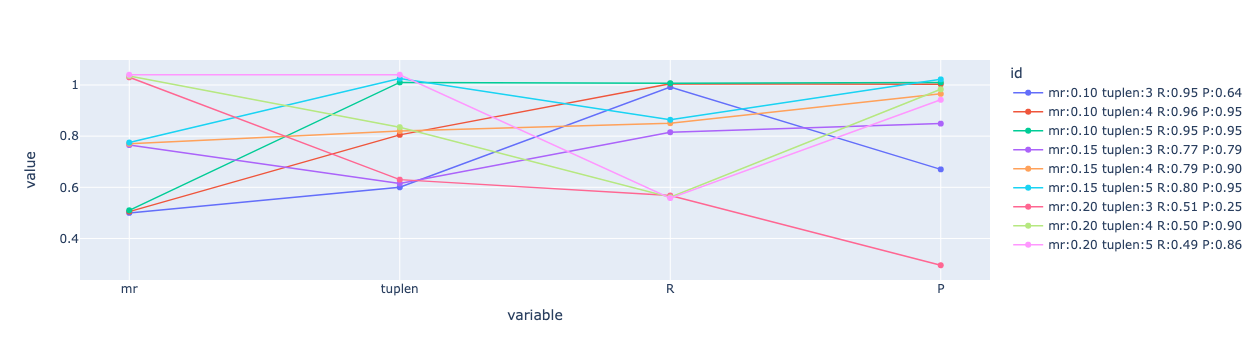

In [219]:
def experiment(conf):
    seqInt = np.random.randint(0,len(alphabet), (conf['N']))
    seqv = alphabet[seqInt]
    seq = ''.join(seqv)
    sketcher = DTS(t=conf['tuplen'], D=conf['m'], D2=conf['m2'], A=len(alphabet)) 
    wmers = [seqInt[i:i+conf['w']] for i in range(0,len(seqInt) - conf['w'] + 1,conf['s'])]
    sketches = sketcher.sketch(wmers)
    lut = build_lookup(sketches, conf['s'])

    paths = generate_paths(seq, conf['path_len'], conf['num_paths'], conf['k'], conf['mr'], alphabet)
    recall, hits, tp, dists = np.zeros((4,conf['num_paths']))
    dists[:] = np.inf

    for i, path in enumerate(tqdm(paths)):
        reference, query, node_path = path
        queryInt = convert(query, alphabet)

        q_wmers = [queryInt[i:i+conf['w']] for i in range(len(queryInt) - conf['w'] + 1)]
        q_sketches = sketcher.sketch(q_wmers)

        # Lookup
        for qi,query_sketch in enumerate(q_sketches):
            if query_sketch not in lut:
                continue
            for node in lut[query_sketch]: # for each node j in the matches
                hits[i] += 1 # count a hit
                ri = (node-node_path[0]) # relative node location to reference head 
                d1 = editdistance.eval(reference[:ri], query[:qi])
                d2 = editdistance.eval(reference[ri:], query[qi:])
                d = editdistance.eval(reference, query)
                dists[i] = min(dists[i],d1+d2-d)
                if(  d1+d2 <= d + conf['recall_dist']):
                    tp[i] += 1
                    recall[i] = 1

    conf['P'] = np.mean(tp[hits>0]/hits[hits>0])  # np.sum(tp)/np.sum(hits) 
    conf['R'] = np.mean(recall) 
    conf['dists_bins'] = list(range(10))
    conf['dists_counts'] = np.histogram(dists,bins=conf['dists_bins']+[np.inf])[0]
    return conf 

def show_board(df, cols):  
    def legend(x):
        leg = []
        for i,s in enumerate(x):
            col = cols[i]
            if int(s)==s:
                leg.append(f'{col}:{int(s)}')
            else:
                leg.append(f'{col}:{s:.2f}')
        return ' '.join(leg)

    df2 = df[cols]
    df2['id'] = df2.apply(lambda x: legend(x.tolist()), axis=1)
    df2[cols] = df2[cols] / df2[cols].max()
    for i in range(len(df2)):
        df2.loc[i,cols] += i*5e-3 # add slight y to make them separately visible
    df2 = pd.melt(df2, id_vars='id',value_vars=cols)
    fig = px.line(df2,x='variable',y='value',color='id')
    fig.update_traces(line=dict(width=1.5),mode="markers+lines")
    fig.show()

results = []
alphabet = np.array(['A','C','G','T'])

for w in [14]:
    config_grid = dict(
        num_paths = 1000,
        N = [int(1e6)],
        mr = [0.1,.15,0.2],
        path_len = 200,
        recall_dist = 0,
        k=w,
        m=[20],
        m2=[2**7],
        tuplen = [3,4,5],
        w = w,
        s = [w],
    )

    for conf in dict_configs(config_grid): 
        result = experiment(conf)
        results.append(result)
        print(conf)    

df = pd.DataFrame(results)

show_board(df,cols = ['mr','tuplen','R','P']) # 'N','w','s',m,m2

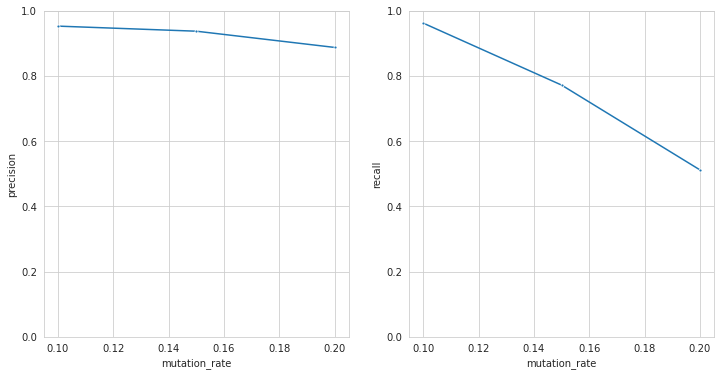

In [42]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(results)
Ys = ['precision', 'recall']
fig,axes = plt.subplots(1,len(Ys),figsize=(len(Ys)*6,6))
for y,ax in zip(Ys,axes):
    sns.set_style("whitegrid")
    sns.lineplot(ax=ax,data=df,y=y,x='mutation_rate',marker='.')#,hue='tuple_length')#,style='embed_dim2')
    ax.set_ylim(0,1)

plt.grid(True)

# Measuring time

In [24]:
times = []
sketcher = DTS(t=conf['tuple_length'], D=conf['embed_dim'], D2=conf['embed_dim2'], A=len(conf['alphabet']))    

for N in [1000000, 2000000,5000000, 10000000]:
    seqv = np.random.choice(conf['alphabet'], N)
    seq = ''.join(seqv)
    wmers = [np.random.randint(0,4,int(15)) for i in range(int(N/15))]
    start = time.time()
    sketcher.sketch(wmers)
    end = time.time()
    print(f'{N}: {end-start}')
    times.append(end-start)


1000000: 0.8351550102233887
2000000: 1.718003511428833
5000000: 4.298624515533447
10000000: 8.454844951629639


# Multi-level sketching

In [ ]:
def sketch_multi(s):
    h = s
    m = conf['w']
    h = [h[i:i+m] for i in range(0,len(h) - m + 1,m)]
    h = np.array(sketcher.sketch(h)) % conf['alpha2']
    h1 = h

    m = conf['m2']
    h = [h[i:i+m] for i in range(0,len(h) - m + 1,m)]
    h = sketcher2.sketch(h)
    h = np.array(h) % conf['alpha3']
    h2 = h

    return h1, h2


w = 10
w2 = 10
alpha = 4


config_grid = dict(
    num_paths = 100,
    N = [200],
    mutation_rate = [0.1],
    path_len = 20*w*w2,
    embed_dim= 20,
    embed_dim2= 2**4,
    recall_distance = 3,
    m = w,
    tuple_length = 2,
    m2 = w2,
    tuple_length2= 4,
    alpha2= 4 ,
    alpha3= 8 ,
)

conf = next( dict_configs(config_grid) )

Len = conf['path_len']
Num = conf['N']
sketcher = DTS(t=conf['tuple_length'], D=conf['embed_dim'], D2=conf['embed_dim2'], A=alpha) 
sketcher2 = DTS(t=conf['tuple_length2'], D=conf['embed_dim'], D2=conf['embed_dim2'], A=conf['alpha2'])   
seqs = np.random.randint(0,alpha,(2,Num,Len))
for i in range(Num):
    I = np.random.permutation(Len)[:np.random.randint(Len)]
    seqs[1,i,I] = seqs[0,i,I] 
seqs = seqs.reshape(2,Num,Len)
Dists = np.zeros((3,Num))
for i in range(Num):
    seq, seq2 = seqs[0,i,:], seqs[1,i,:]
    h, H = sketch_multi(seq)
    h2,H2 = sketch_multi(seq2)
    d1 = editdistance.eval(seq, seq2)
    d2 = editdistance.eval(h, h2)
    d3 = editdistance.eval(H, H2)
    d3 = np.mean(H!=H2)
    Dists[:,i] = (d1,d2,d3)

fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].scatter(Dists[0]/Len,Dists[1],10,alpha=.5)
axes[1].scatter(Dists[0]/Len,Dists[2],10,alpha=.5)